In [77]:
import glob
import os
import pandas as pd
import numpy as np
import librosa.display as display
import matplotlib.pyplot as plt
%matplotlib inline

import pretty_midi


from IPython.display import clear_output

# Simplifying the dataset

[We've listed all the instruments present by count](/notebooks/notebooks/Load%20Instruments.ipynb) so we'll build on the work in that notebook, by loading the csv file it has produced.

We will want to only focus on training melodies for one set for now, so it makes sense to pick an instrument (program code), that is present in large quantities, and is likely to have long melodies to train on. We'll focus on one of the most popular instruments. You'll notice the name column has a large count. The name appears to be a free text field for description of the intention of this track in the MIDI file, the program is the instrument used.

Because these midi files are created by humans, there's a risk that people will intend for a track to be a certain type, but have used a program they liked the sound of in their midi engine when creating the track. It is common for vocals to be coded as Strings, (52 Choir Aahs, 53 Voice Oohs), for instance. We're going to disregard this problem for now, and assume the program codes are accurate.

In [83]:
instruments = pd.read_csv('instruments.csv', sep=';')
# Show the instrument with the most unique filepath values
grouped = pd.read_csv('frequent_track.csv', sep=';')
grouped.head(n=7)

/home/victorunix/anaconda3/envs/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (0,1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,program,is_drum,name,filepath
0,0,2,14923,92919
1,33,2,4475,34051
2,25,2,5008,32062
3,48,2,4545,32041
4,35,2,2772,27388
5,27,2,3358,20527
6,49,2,3118,19539


In [86]:
# Translate the program codes to instrument names
for program in grouped.head(n=7).index.values:
    print(pretty_midi.program_to_instrument_name(int(program)))

Acoustic Grand Piano
Bright Acoustic Piano
Electric Grand Piano
Honky-tonk Piano
Electric Piano 1
Electric Piano 2
Harpsichord


The top instrument used is 0: Acoustic Grand Piano.

It doesn't seem to be the most realiable program of them all, so it does point towards this being used for a bunch of different stuff.
We'll continue inspecting this.

In [87]:
instruments[(instruments['program'] == 0)].head(n=10)

,Unnamed: 0,program,is_drum,name,filepath
262147,262118,0,True,GM Drums,data/lmd_aligned/Q/G/R/TRQGRXB128E078AA08/f1a4...
262156,262127,0,True,NaN,data/lmd_aligned/Q/G/R/TRQGRXB128E078AA08/a0c0...
262165,262136,0,True,Drums,data/lmd_aligned/Q/G/R/TRQGRXB128E078AA08/7ded...
262175,262146,0,True,Drums,data/lmd_aligned/Q/G/R/TRQGRXB128E078AA08/887a...
262185,262156,0,True,Drums,data/lmd_aligned/Q/G/R/TRQGRXB128E078AA08/f870...
262187,262158,0,True,Drums,data/lmd_aligned/Q/G/R/TRQGRXB128E078AA08/b339...
262188,262159,0,False,Piano,data/lmd_aligned/Q/G/R/TRQGRXB128E078AA08/b339...
262201,262172,0,True,NaN,data/lmd_aligned/Q/G/R/TRQGRST128F429E937/9e08...
262202,262173,0,True,NaN,data/lmd_aligned/Q/G/R/TRQGRST128F429E937/9e08...
262203,262174,0,True,NaN,data/lmd_aligned/Q/G/R/TRQGRST128F429E937/9e08...


Not exactly all pianos.
Let's try to filter for names that contain the word "piano". Much better. But now we're reduced to only 8000 files. It'll have to do for now.

In [89]:
pianos = instruments[(instruments['program'] == 0) & (instruments['name'].str.contains('piano', case=False))]
print(len(pianos))
pianos.head(n=6)

7707


,Unnamed: 0,program,is_drum,name,filepath
262188,262159,0,False,Piano,data/lmd_aligned/Q/G/R/TRQGRXB128E078AA08/b339...
262293,262264,0,False,A.PIANO 1,data/lmd_aligned/Q/G/K/TRQGKIC12903CC3C01/27c7...
262355,262326,0,False,PIANO,data/lmd_aligned/Q/G/F/TRQGFOY128F1491F3D/2718...
262356,262327,0,False,PIANO,data/lmd_aligned/Q/G/F/TRQGFOY128F1491F3D/2718...
262363,262334,0,False,Piano (Left Hand),data/lmd_aligned/Q/G/F/TRQGFOY128F1491F3D/9c54...
262364,262335,0,False,Piano (Right Hand),data/lmd_aligned/Q/G/F/TRQGFOY128F1491F3D/9c54...


# Loading all files for the instrument

We'll iterate over our piano list and load all the midi files, get the piano rolls and save the result as a CSV for later consumption. This will take a few minutes, since parsing takes long in itself.

In [90]:
note_columns = [pretty_midi.note_number_to_name(n) for n in range(0,128)]
def encode_dummies(instrument, sampling_freq):
    """ Gonna cheat a little bit by transposing the instrument piano roll. 
        However, that leaves us with a lot of blank space. 
        Coercing to type uint8, since the max velocity is 127, and there are also only 128 notes. uint8 goes to 255.
        Saves memory
    """
    pr = instrument.get_piano_roll(fs=sampling_freq).astype('uint8').T
    return pd.DataFrame(pr, columns=note_columns)

def trim_blanks(df):
    """
        Remove the first period of no activity (fast forward to where the first note begins for this instrument)
    """
    nonzero = df.apply(lambda s: s != 0)
    nonzeroes = df[nonzero].apply(pd.Series.first_valid_index)
    first_nonzero = nonzeroes.min()
    if first_nonzero is pd.np.nan:
        return None
    return df.iloc[int(first_nonzero):]

"""
    Create a pandas to store the piano rolls in.
    It'll look a bit like this:
    
    |   Index     | t | C0 |...| C10 |
    |Song_name_3:0| 0 | 40 |...| 0   |
    |             | 1 | 40 |...| 0   |
    |             |...|... |...| ... |
    |             | N | 40 |...| 0   |
    |Song_name_3:1| 0 | 40 |...| 0   |
    |             |...|... |...| ... |
    |             | N | 40 |...| 0   |
    |Song_name_4:0| 0 | 40 |...| 0   |
    |             |...|... |...| ... |
    |             | N | 40 |...| 0   |

"""
saved_columns = [pretty_midi.note_number_to_name(n) for n in range(48,108)]
piano_rolls = pd.DataFrame(columns=['piano_roll_name', 'timestep'] + saved_columns)
piano_rolls = piano_rolls.set_index(['piano_roll_name', 'timestep'])
piano_rolls.head()

,,C3,C#3,D3,D#3,E3,F3,F#3,G3,G#3,A3,...,D7,D#7,E7,F7,F#7,G7,G#7,A7,A#7,B7
piano_roll_name,timestep,,,,,,,,,,,,,,,,,,,,,


In [91]:
# Chops off the upperbound and lowerbound of zeros
# The lower bound note is set a C, which might make it easier
# to make the MIDI play in the same key.
def chopster(dframe):
    # Figure out range of frame (0-128)
    df_max = dframe.max(axis = 0)
    
    dframe.drop(labels=[pretty_midi.note_number_to_name(n) for n in range(108,128)], axis=1, inplace=True)
    dframe.drop(labels=[pretty_midi.note_number_to_name(n) for n in range(0,48)], axis=1, inplace=True)
    return dframe
#     for i in range(len(df_max)-1, 0, -1):
#         if df_max[i] != 0:
#             upper_bound_C = i
#             for j in range(len(df_max)):
#                 if df_max[j] != 0:
#                     lower_bound_C = j-(j%12)
#                     dframe.drop(labels=[pretty_midi.note_number_to_name(n) for n in range(upper_bound_C,128)], axis=1, inplace=True)
#                     dframe.drop(labels=[pretty_midi.note_number_to_name(n) for n in range(0,lower_bound_C)], axis=1, inplace=True)
                    
#                     break
#             break
#     return dframe

# Non-zero values changed to 1's
def minister(dframe):
    return dframe.where(dframe<1, 1)


# Removes chords and turns them into melody
def arpster(dframe):
    # Count amount of notes being played at once.
    note_amount = np.asarray(dframe.astype(bool).sum(axis=1))
    i = 0
    
    # Slide through whole MIDI
    while i < dframe.shape[0]:
        # Check if note is single
        if note_amount[i] == 1:
            i += 1
            continue
        elif note_amount[i] > 1: 
            hits = 0
            hit_index = []
            # Calculates the amount of notes being played
            for j in range(dframe.shape[1]):
                if dframe.iloc[i,j] == 1:
                    hit_index.append(j)
                    hits += 1
                    if hits == note_amount[i]:
                        break

            length = 0
            
            # Removes all notes such that chords are turned into arpeggios.
            # Ensures that all values in hit_index are the same as ones in 
            # dframe row.
            while False not in (dframe.iloc[i+length, hit_index] == 1).values:
                for k in range(len(hit_index)):
                    if k != (length % hits):
                        dframe.iloc[i+length, hit_index[k]] = 0
                length += 1
                if len(note_amount) <= i+length or note_amount[i+length-1] != note_amount[i+length]:
                    break

            # Skip ahead to next note
            i += length
                
        # Maybe a case where we count ithe amount of silent steps going ahead
        elif note_amount[i] == 0:
            i += 1
            continue
        
    return dframe

# Chops up into desired window size.
# and maybe saves them to csv in this step?
# frame_size: amount of measures pr input
def cutster(dframe, frame_size, undesired_silence):
    # Chop up if the window size fits the music
    
    # Check if frame size is greater than MIDI length
    # Pad with zeros
    if frame_size > dframe.shape[0]/16:
        return dframe
    
    note_amount = np.asarray(dframe.astype(bool).sum(axis=1))
    zero_amount = 0
    
    df_dictionary = {}
    dict_index = 0
    
    divider = 0
    i = 0
    while i < len(note_amount):
        # Cuts out silent measures if greater than undesired_silence
        if zero_amount/16 > undesired_silence and note_amount[i] != 0:
            drop_amount = [j for j in range(i-zero_amount,i)]
            dframe.drop(drop_amount, inplace=True)
            note_amount = np.delete(note_amount, drop_amount)
            i -= zero_amount-1
            zero_amount = 0
            
        elif note_amount[i] != 0:
            if zero_amount != 0:
                zero_amount = 0
            i += 1
        # Count sequential zeros
        elif note_amount[i] == 0:
            zero_amount += 1
            i += 1
        
    return dframe

# Add desired amount of padding to 
# all MIDI files such that they contain 
# the same amount of dimensions.
def padster(dframe):
    # Find MIDI piece with most keys used
    # Pad all others such they fit the dimensions
    return dframe.fillna(0)
    
    

In [94]:
# DISCLAIMER:
# This file is inspired by Nick Kelly by his article on tranposing MIDI files.
# http://nickkellyresearch.com/python-script-transpose-midi-files-c-minor/
import music21

# Transpose MIDI to same key (C major or A minor)
def transposer(midi_file):
    midi_array = midi_file.split('/')

    # converting everything into the key of C major or A minor
    # Major conversion
    majors = dict([("A-", 4),("G#", 4),("A", 3),("A#", 2),("B-", 2),("B", 1),("C", 0),("C#", -1),("D-", -1),("D", -2),("D#", -3),("E-", -3),("E", -4),("F", -5),("F#", 6),("G-", 6),("G", 5)])
    # Minor conversion
    minors = dict([("G#", 1), ("A-", 1),("A", 0),("A#", -1),("B-", -1),("B", -2),("C", -3),("C#", -4),("D-", -4),("D", -5),("D#", 6),("E-", 6),("E", 5),("F", 4),("F#", 3),("G-", 3),("G", 2)])

    score = music21.converter.parse(midi_file)
    key = score.analyze('key')
    if key.mode == "major":
        halfSteps = majors[key.tonic.name]

    elif key.mode == "minor":
        halfSteps = minors[key.tonic.name]

    return halfSteps

# Parsing the data to csv

The following step takes too long and is projected to take up roughly 30gb of space - so let's do some more splitting work on it (to reduce breaks between segments). Maybe consider cutting away large parts of the tonal range, such as only using songs where the instruments are between C4 and C8 or something.

Alternatively, we can load in the files directly during training in a data loader, but I'd like to clean and split the songs beforehand so they're easier to train on. We could split all the songs into x-bar segments and save them as .mid files in a processed folder. Should take up less space and be easier.

In [95]:
start = 0
limit = -1
skip = [1593, 2709]
file_name = 'piano_rolls.csv'
piano_rolls.to_csv(file_name, sep=';', encoding='utf-8')

# This might take a while...
for i, file in enumerate(pianos['filepath'][start:limit]):
    if i in skip:
        print("Skipping {}...".format(i))
        continue
    
    clear_output(wait=True)
    song_name = os.path.basename(file)
    print("{}/{}: {}.".format(i, len(pianos), song_name))
    try:
        semi_shift = transposer(file)
        pm = pretty_midi.PrettyMIDI(file)
        print("Loaded into memory, processing...")
        """
            Here we calculate the amount of seconds per sixteenth note, by taking the second beat of the song 
            (which is the same as the difference in seconds between the first and second beat),
            and convert it to the sampling frequency format that pretty_midi expects.
        """
        sampling_freq = 1/ (pm.get_beats()[1]/4)
    except Exception as e:
        # For now, just ignore files we can't load.
        print("Ignoring song {}: {}".format(song_name, e))
        continue
    for j, instrument in enumerate(pm.instruments):
        # Hardcoded for now:
        if instrument.program == 0 and 'piano' in instrument.name.lower():
            """
                Generate a unique top level index per song and instrument in this song,
                if it has multiples of the same kind.
            """
            for note in instrument.notes:
                note.pitch += semi_shift
            
            try:
                df = encode_dummies(instrument, sampling_freq).fillna(value=0) # Fill invalid values
            except Exception as e:
                # Something is really wrong if this fails. Means the piano roll is bad - don't use this track
                print("Encountered exception for song {}, instrument {}: {}".format(song_name, instrument.name, e))
                continue
            
            print("One hot encoded")
            # chop before doing anything else to conserve memory
            df = chopster(df)
            print("Chopped to relevant notes only")
            
            df = trim_blanks(df)
            print("Fast forwarded to first note playing")
            if df is None:
                # We've got an empty track
                continue
            

            df = minister(df)
            print("Reduced velocity to on/off")
            
            df = arpster(df)
            print("Arpeggiated chords")
            
            # ensures that files with more than 1 note pr timestep is not added to the dataset.
            if np.amax(np.asarray(df.astype(bool).sum(axis=1))) > 1:
                continue
                # raise Exception('More than one key pressed at timestep {0}'.format(np.unique(ar = note_amount, return_index = True, return_counts = True)[1][2:]))

            df.reset_index(inplace=True, drop=True)
            #new_df = cutster(df, 8, 1)
            #df.reset_index(drop=True)

            top_level_index = "{}_{}:{}".format(song_name, i, j)
            df['timestep'] = df.index
            df['piano_roll_name'] = top_level_index
            df = df.set_index(['piano_roll_name', 'timestep'])
            df.to_csv(file_name, sep=';', mode='a', encoding='utf-8', header=False)
            

276/7707: 0eeaa947af2669e9b553a25d13f29622.mid.


KeyboardInterrupt: 

                                                   C3  C#3  D3  D#3  E3  F3  \
piano_roll_name                          timestep                             
b33965cd3cb234ec7df3ac38246b6248.mid_0:1 0          0    0   0    0   0   1   
                                         1          0    0   0    0   0   0   
                                         2          0    0   0    0   0   0   
                                         3          0    0   0    0   0   0   
                                         4          0    0   0    0   0   1   

                                                   F#3  G3  G#3  A3  ...  D7  \
piano_roll_name                          timestep                    ...       
b33965cd3cb234ec7df3ac38246b6248.mid_0:1 0           0   0    0   0  ...   0   
                                         1           0   0    0   0  ...   0   
                                         2           0   0    0   0  ...   0   
                                         3    

/home/victorunix/anaconda3/envs/anaconda3/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


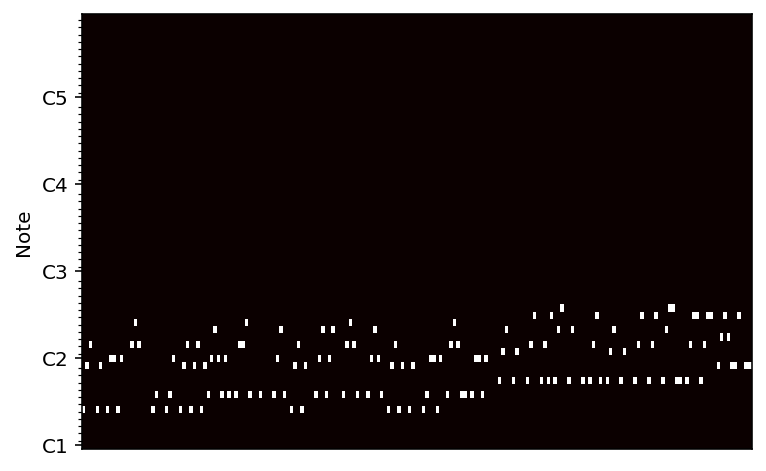

In [98]:
rolls = pd.read_csv("piano_rolls.csv", sep=';', index_col=['piano_roll_name', 'timestep'])
print(rolls.head())
print(rolls.index.levels[0])
#rolls = padster(rolls)
first = rolls.loc['b33965cd3cb234ec7df3ac38246b6248.mid_0:1'].T
display.specshow(first.values, y_axis='cqt_note', cmap=plt.cm.hot)

In [99]:
rolls = rolls.loc[:, (rolls != 0).any(axis=0)]
rolls.tail(n=16)

C3  C#3  D3  D#3  E3  F3  \
piano_roll_name                            timestep                             
a400c51383e08cb998361857321d192f.mid_275:2 95         0    0   0    0   0   0   
                                           96         0    0   0    0   0   0   
                                           97         0    0   0    0   0   0   
                                           98         0    0   1    0   0   0   
                                           99         0    0   0    0   0   1   
                                           100        0    0   1    0   0   0   
                                           101        0    0   1    0   0   0   
                                           102        0    0   0    0   0   0   
                                           103        0    0   0    0   0   0   
                                           104        0    0   0    0   0   0   
                                           105        0    0   0    0   0   0   
                                           106        0    0   0    0   0   0   
                                           107        0    0   0    0   0   0   
                                           108        0    0   0    0   0   0   
                                           109        0    0   0    0   0   0   
                                           110        0    0   0    0   0   0   

                                                     F#3  G3  G#3  A3  ...  \
piano_roll_name                            timestep                    ...   
a400c51383e08cb998361857321d192f.mid_275:2 95          0   0    0   0  ...   
                                           96          0   0    0   0  ...   
                                           97          0   0    0   0  ...   
                                           98          0   0    0   0  ...   
                                           99          0   0    0   0  ...   
                                           100         0   0    0   0  ...   
                                           101         0   0    0   0  ...   
                                           102         0   0    0   0  ...   
                                           103         0   0    0   0  ...   
                                           104         0   0    0   0  ...   
                                           105         0   0    0   0  ...   
                                           106         0   0    0   0  ...   
                                           107         0   0    0   0  ...   
                                           108         0   0    0   0  ...   
                                           109         0   0    0   0  ...   
                                           110         0   0    0   0  ...   

                                                     D#6  E6  F6  G6  G#6  A6  \
piano_roll_name                            timestep                             
a400c51383e08cb998361857321d192f.mid_275:2 95          0   0   0   0    0   0   
                                           96          0   0   0   0    0   0   
                                           97          0   0   0   0    0   0   
                                           98          0   0   0   0    0   0   
                                           99          0   0   0   0    0   0   
                                           100         0   0   0   0    0   0   
                                           101         0   0   0   0    0   0   
                                           102         0   0   0   0    0   0   
                                           103         0   0   0   0    0   0   
                                           104         0   0   0   0    0   0   
                                           105         0   0   0   0    0   0   
                                           106         0   0   0   0    0   0   
                                           107         